In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# The Story of Sagaing

As early as April 11, 2023, the Myanmar military used "thermobaric" munition for an attack on the oppoisition building. The region of Sagaing has seen conflict consistently since early 2021 when the government led by Aung San Suu Kyi’s party was overthrown by the military. In this notebook we see some correlations between ACLED Conflict Index data and change in Night Time Lights in Sagaing.

In [4]:
myanmar_adm3 = gpd.read_file(
    "../../data/shapefiles/mmr_polbnda_adm3_250k_mimu/mmr_polbnda_adm3_250k_mimu.shp"
)
myanmar_adm2 = gpd.read_file(
    "../../data/shapefiles/mmr_polbnda_adm2_250k_mimu_1/mmr_polbnda_adm2_250k_mimu_1.shp"
)
myanmar_adm1 = gpd.read_file(
    "../../data/shapefiles/mmr_polbnda2_adm1_250k_mimu/mmr_polbnda2_adm1_250k_mimu.shp"
)

sez = gpd.read_file(
    "../../data/shapefiles/industrial__special_economic_zones_sept2019/industrial__special_economic_zones_sept2019.shp"
)
sez_hdx = gpd.read_file(
    "../../data/shapefiles/industrial__special_economic_zones_sept2019_hdx/industrial__special_economic_zones_sept2019.shp"
)
ntl_sez = pd.read_csv("../../data/night-time-lights/admsez_VNP46A3.csv")
ntl_adm2 = pd.read_csv("../../data/night-time-lights/adm2_VNP46A3.csv")
ntl_adm3 = pd.read_csv("../../data/night-time-lights/adm3_VNP46A4.csv")
ntl_adm1 = pd.read_csv("../../data/night-time-lights/adm1_VNP46A3.csv")

acled = pd.read_csv("../../data/conflict/2012-01-01-2023-05-16-Myanmar.csv")
conflict = pd.read_csv("../../data/conflict/conflict_data_mmr.csv")

In [5]:
from datetime import datetime

acled["event_date"] = acled["event_date"].apply(
    lambda x: datetime.strptime(x, "%d %B %Y")
)

acled = acled[acled["event_type"] != "Strategic developments"]
acled = acled[acled["event_date"] >= "2020-01-01"]

In [7]:
from shapely.geometry import Point


def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [12]:
from scipy.stats import gmean


def get_acled_by_admin(
    myanmar_adm2, acled, columns=["DT", "DT_PCODE", "ST"], nearest=False
):
    acled_adm2 = convert_to_gdf(acled)
    if nearest == True:
        acled_adm2 = (
            myanmar_adm2.sjoin_nearest(acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby([pd.Grouper(key="event_date", freq="M", closed="left")] + columns)[
                "fatalities"
            ]
            .agg(["sum", "count"])
            .reset_index()
        )
    else:
        acled_adm2 = (
            myanmar_adm2.sjoin(acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby([pd.Grouper(key="event_date", freq="M", closed="left")] + columns)[
                "fatalities"
            ]
            .agg(["sum", "count"])
            .reset_index()
        )
    acled_adm2.rename(columns={"sum": "fatalities", "count": "nrEvents"}, inplace=True)
    acled_adm2["conflictIndex"] = acled_adm2.apply(
        lambda row: gmean([row["nrEvents"], row["fatalities"]]), axis=1
    )
    acled_adm2["event_date_map"] = acled_adm2["event_date"].apply(
        lambda x: x.date().replace(day=1)
    )

    return acled_adm2.reset_index()


# .pivot(index = 'DT_PCODE', columns='event_date').sort_values(by='DT_PCODE')

In [60]:
acled_adm2_disagg = convert_to_gdf(acled)
acled_adm2_disagg = (
    myanmar_adm2.sjoin(acled_adm2_disagg)[
        ["event_date", "fatalities", "event_type", "sub_event_type"] + ["ST"]
    ]
    .groupby(
        [
            "event_type",
            "sub_event_type",
            pd.Grouper(key="event_date", freq="M", closed="left"),
        ]
        + ["ST"]
    )["fatalities"]
    .agg(["sum", "count"])
    .reset_index()
)

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [13]:
acled_adm2 = get_acled_by_admin(myanmar_adm2, acled)

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [14]:
ntl_adm1["date"] = ntl_adm1["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
ntl_adm2["date"] = ntl_adm2["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
ntl_adm2["date_map"] = ntl_adm2["date"].apply(lambda x: x.date())

In [15]:
ntl_adm2["NAME_2"].replace(
    {
        "Yangon-E": "Yangon (East)",
        "Yangon-W": "Yangon (West)",
        "Yangon-N": "Yangon (North)",
        "Yangon-S": "Yangon (South)",
    },
    inplace=True,
)
df = ntl_adm2.merge(
    acled_adm2, left_on=["date_map", "NAME_2"], right_on=["event_date_map", "DT"]
)

## Events that occured in Sagaing since 2021

* The military torched homes in Sagaing in September 2021. [News Report](https://www.aljazeera.com/news/2021/9/23/myanmar-violence-erupts)
* August - October 2022 there was a cutoff of internet [News Report](https://engagemedia.org/2023/myanmar-digital-coup-quarterly-august-october-2022/)

Text(0.5, 1.0, 'Correlation between conflict index and Night Time Lights in Sagaing')

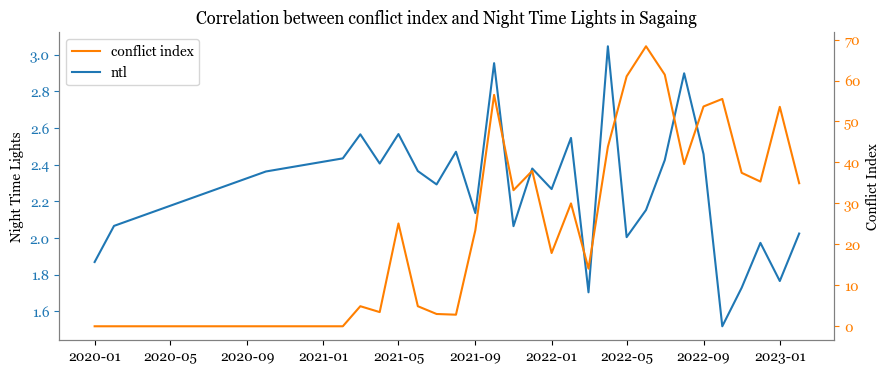

In [42]:
plt.rcParams["font.family"] = "Georgia"

plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
ax = axs  # .flatten()

# for i, ST in enumerate(['Sagaing']):
df1 = df[df["NAME_2"] == "Sagaing"]
ax.plot(df1["date"], df1["ntl_bm_mean"], "#1F77B4", label="ntl")
ax.set_ylabel("Night Time Lights")
ax.tick_params("y", colors="#1F77B4")

ax1 = ax.twinx()
ax1.plot(df1["date"], df1["conflictIndex"], "#FF7F00", label="conflict index")
ax1.set_xlabel("x")
ax1.set_ylabel("Conflict Index")
ax1.tick_params("y", colors="#FF7F00")

ax1.spines["top"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color("grey")
ax1.spines["left"].set_color("grey")
ax.spines["right"].set_color("grey")
ax1.spines["right"].set_color("grey")
ax.spines["bottom"].set_color("grey")
ax1.spines["bottom"].set_color("grey")


lines = ax1.get_lines() + ax.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="upper left")


ax.set_title("Correlation between conflict index and Night Time Lights in Sagaing")

In [67]:
acled_adm2_disagg[
    (acled_adm2_disagg["ST"] == "Sagaing")
    & (acled_adm2_disagg["event_date"] == "2021-10-31")
]

,event_type,sub_event_type,event_date,ST,sum,count
167,Battles,Armed clash,2021-10-31,Sagaing,451,59
494,Explosions/Remote violence,Air/drone strike,2021-10-31,Sagaing,0,2
676,Explosions/Remote violence,Grenade,2021-10-31,Sagaing,0,3
932,Explosions/Remote violence,Remote explosive/landmine/IED,2021-10-31,Sagaing,288,106
1305,Explosions/Remote violence,Shelling/artillery/missile attack,2021-10-31,Sagaing,0,7
1782,Protests,Peaceful protest,2021-10-31,Sagaing,0,93
2130,Violence against civilians,Abduction/forced disappearance,2021-10-31,Sagaing,0,2
2452,Violence against civilians,Attack,2021-10-31,Sagaing,86,70


In [68]:
acled_adm2_disagg[
    (acled_adm2_disagg["ST"] == "Sagaing")
    & (acled_adm2_disagg["event_date"] == "2022-06-30")
]

,event_type,sub_event_type,event_date,ST,sum,count
293,Battles,Armed clash,2022-06-30,Sagaing,644,111
529,Explosions/Remote violence,Air/drone strike,2022-06-30,Sagaing,15,8
721,Explosions/Remote violence,Grenade,2022-06-30,Sagaing,0,2
1063,Explosions/Remote violence,Remote explosive/landmine/IED,2022-06-30,Sagaing,172,68
1389,Explosions/Remote violence,Shelling/artillery/missile attack,2022-06-30,Sagaing,21,39
1851,Protests,Peaceful protest,2022-06-30,Sagaing,0,103
2191,Violence against civilians,Abduction/forced disappearance,2022-06-30,Sagaing,0,8
2578,Violence against civilians,Attack,2022-06-30,Sagaing,118,55
2746,Violence against civilians,Sexual violence,2022-06-30,Sagaing,0,1


In [70]:
acled_adm2_disagg[
    (acled_adm2_disagg["ST"] == "Sagaing")
    & (acled_adm2_disagg["event_date"] == "2022-10-31")
]

,event_type,sub_event_type,event_date,ST,sum,count
355,Battles,Armed clash,2022-10-31,Sagaing,202,82
564,Explosions/Remote violence,Air/drone strike,2022-10-31,Sagaing,8,31
742,Explosions/Remote violence,Grenade,2022-10-31,Sagaing,10,5
1125,Explosions/Remote violence,Remote explosive/landmine/IED,2022-10-31,Sagaing,108,45
1440,Explosions/Remote violence,Shelling/artillery/missile attack,2022-10-31,Sagaing,10,26
1874,Protests,Peaceful protest,2022-10-31,Sagaing,0,86
2223,Violence against civilians,Abduction/forced disappearance,2022-10-31,Sagaing,0,7
2637,Violence against civilians,Attack,2022-10-31,Sagaing,47,23
